In [ ]:
# -*- coding: utf-8 -*-
"""Copy of ML_thesis.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1kmQzTD0tBVVAHHdG5J0iLnWmwlGUUeEW
"""

import time
start_time = time.time()
# print('start_time: ', start_time)

!pip install PySimpleGUI
import torch
import PySimpleGUI as sg

!pip install matplotlib
import tkinter as tk
import matplotlib
matplotlib.use('TkAgg')

from matplotlib.backends.backend_tkagg import FigureCanvasAgg
import matplotlib.backends.backend_tkagg as tkagg
import tkinter as Tk


import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sys
import pickle

from torch import nn, optim

#from torchvision import transforms
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

scaler1 = MinMaxScaler()  
scaler2 = MinMaxScaler()

no_of_output_nodes = 15

#df_1 = pd.read_excel("pcf_modeSoln_data_1.xlsx", sheet_name="SiO2-air-rings-5-dBYp-0.7")
df_1 = pd.read_excel("PCF_training - Copy.xlsx", sheet_name="SiO2-air-rings-5-dBYp-0.7")
datafile_1 = df_1.values                  ## stored data from xlsx file
#print(datafile_1)

##########    taking data from other sheets    #############
sheets_names = ["SiO2-air-rings-4-dBYp-0.8", "SiO2-air-rings-4-dBYp-0.9", 
                "SiO2-air-rings-4-dBYp-0.7", "SiO2-air-rings-5-dBYp-0.6", 
                "SiO2-air-rings-5-dBYp-0.8", "SiO2-air-rings-5-dBYp-0.9",
                "SiO2-air-rings-4-dBYp-0.6"]
# sheets_names = []
for sheet_name in sheets_names:
    print(sheet_name)
    #df_sheet_name = pd.read_excel("pcf_modeSoln_data_1.xlsx", sheet_name=sheet_name)
    df_sheet_name = pd.read_excel("PCF_training - Copy.xlsx", sheet_name=sheet_name)
    datafile_sheet_name = df_sheet_name.values                  ## stored data from xlsx file
    #print(datafile_sheet_name)
    #########    combining data from all sheets of excel file    #########
    datafile_1 = np.concatenate((datafile_1, datafile_sheet_name), axis=0)


print(datafile_1)
print(len(datafile_1))
print()

########   just to see output variable values   ##########
out_var_datafile_1 = datafile_1[:,range(6,21)]              ## stored output_variable (4th column) from xlsx file
out_var_datafile_1 = out_var_datafile_1.reshape((-1,no_of_output_nodes))    ## one column with unknown no. of rows
print(out_var_datafile_1)
print('no. of training points: ', len(out_var_datafile_1))

scaler1.fit(datafile_1)
scaler2.fit(out_var_datafile_1)

scaler_datafile_1 = scaler1.transform(datafile_1)
X = scaler_datafile_1[:,range(0,6)]                 ## input variables columns
y = scaler_datafile_1[:,range(6,21)]

print(X)
print()
print(y)

X, y = shuffle(X, y)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1)
X_train = X_train.reshape(-1, 6)                                ## 2nd column value is = no. of input variables columns
y_train = y_train.reshape(-1, no_of_output_nodes)               ## 2nd column value is = no. of output variables columns
X_validation = X_validation.reshape(-1, 6)                      ## 2nd column value is = no. of input variables columns
y_validation = y_validation.reshape(-1, no_of_output_nodes)     ## 2nd column value is = no. of output variables columns
print('no. of training points: ', len(X_train))
print('no. of validation points: ', len(X_validation))

###########     manual testing    #########
#df_2 = pd.read_excel("pcf_modeSoln_data_manual_1.xlsx", sheet_name="Sheet1")
df_2 = pd.read_excel("PCF_test - Copy.xlsx", sheet_name="Sheet1")
datafile_2 = df_2.values                  ## stored data from xlsx file
print(datafile_2)
scaler_datafile_2 = scaler1.transform(datafile_2)
X_test = scaler_datafile_2[:,range(0,6)]            ## input variables columns
y_test = scaler_datafile_2[:,range(6,21)]                     ## output variables columns
print(X_test)
print()
print(y_test)
print('no. of test points: ', len(X_test))
X_test = X_test.reshape(-1, 6)                      ## 2nd column value is = no. of input variables columns
y_test = y_test.reshape(-1, no_of_output_nodes)     ## 2nd column value is = no. of output variables columns
###########################################

input_dim = 6                                       ## = no. of input variables columns
output_dim = no_of_output_nodes                     ## = no. of output variables columns
from collections import OrderedDict

# ############     model without dropout     #####################
# nodes_hidden_1 = 20
# nodes_hidden_2 = 20
# ## nn.Linear() is fully connected layer
# model = nn.Sequential(OrderedDict([
#                         ('fc1', nn.Linear(input_dim, nodes_hidden_1)),
#                         ('relu', nn.ReLU()),
#                         ('fc2', nn.Linear(nodes_hidden_1, nodes_hidden_2)),
#                         ('relu', nn.ReLU()),
#                         ('fc3', nn.Linear(nodes_hidden_2, output_dim)),
#                         ]))




############     model with dropout - 3 layers    #####################
####             dropout_prob leads to variations in mse curve      #########
dropout_prob = 0.25
nodes_hidden_1 = 50
nodes_hidden_2 = 50
nodes_hidden_3 = 50
## nn.Linear() is fully connected layer
model = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(input_dim, nodes_hidden_1)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc2', nn.Linear(nodes_hidden_1, nodes_hidden_2)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc3', nn.Linear(nodes_hidden_2, nodes_hidden_3)),
                        ('relu', nn.ReLU()),
                        ('dropout', nn.Dropout(dropout_prob)),
                        ('fc4', nn.Linear(nodes_hidden_3, output_dim)),
                        ]))



# ############     model with dropout - 2 layers     #####################
# ####             dropout_prob leads to variations in mse curve    ###########
# dropout_prob = 0.1           # 0.5 - used in nvidia model-behavioural cloning
# nodes_hidden_1 = 50
# nodes_hidden_2 = 50
# ## nn.Linear() is fully connected layer
# model = nn.Sequential(OrderedDict([
#                         ('fc1', nn.Linear(input_dim, nodes_hidden_1)),
#                         ('relu', nn.ReLU()),
#                         ('dropout', nn.Dropout(dropout_prob)),
#                         ('fc2', nn.Linear(nodes_hidden_1, nodes_hidden_2)),
#                         ('relu', nn.ReLU()),
#                         ('dropout', nn.Dropout(dropout_prob)),
#                         ('fc3', nn.Linear(nodes_hidden_2, output_dim)),
#                         ]))

print(model)
# model.double()
# print(X_train)
print(X_train.shape, y_train.shape)

criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(device)
## move model to gpu if available, else cpu
# model.to(device)

epochs = 25000
# Convert numpy array to torch Variabl
# inputs = torch.from_numpy(X_train).requires_grad_()
# labels = torch.from_numpy(y_train)
inputs = torch.Tensor((X_train))
labels = torch.Tensor((y_train))
inputs_validation = torch.Tensor((X_validation))
labels_validation = torch.Tensor((y_validation))
running_loss = []
running_loss_validation = []
for epoch in range(epochs):
    epoch += 1
        
    #################   train the model   ######################
    model.train()    # prep model for training
    # Clear gradients w.r.t. parameters, else gradients will be added up with every previous pass
    optimizer.zero_grad() 
    # Forward to get output
    outputs = model(inputs)
    # Calculate Loss
    loss = criterion(outputs, labels)       ## mean squared error
    # Getting gradients w.r.t. parameters
    loss.backward()
    # Updating parameters
    optimizer.step()         ## take a step with optimizer to update the weights
    running_loss.append(loss.item())

    
    
    # ###############    validate the model (not showing fluctuations)      ###################
    # # Turn off gradients for validation, saves memory and computations
    # with torch.no_grad():
    #     ## this turns off dropout for evaluation mode of model
    #     model.eval()      # prep model for evaluation
    #     outputs_validation = model(inputs_validation)
    #     loss_validation = criterion(outputs_validation, labels_validation)
    #     running_loss_validation.append(loss_validation.item())
    


    # ###############    validate the model (showing fluctuations)      ###################
    outputs_validation = model(inputs_validation)
    loss_validation = criterion(outputs_validation, labels_validation)
    running_loss_validation.append(loss_validation.item())
        
    

    #print('epoch: {}, mse_loss: {:.6f}, mse_loss_validation: {:.6f}'.format(epoch, loss.item(), loss_validation.item()))
    # print(mean_squared_error(outputs_validation,labels_validation))



    if (epoch == 1000):
        torch.save(model.state_dict(), 'checkpoint_1000.pth')
    elif (epoch == 2500):
        torch.save(model.state_dict(), 'checkpoint_2500.pth')
    elif (epoch == 3500):
        torch.save(model.state_dict(), 'checkpoint_3500.pth')
    elif (epoch == 4900):
        torch.save(model.state_dict(), 'checkpoint_4900.pth')
    elif (epoch == 5000):
        torch.save(model.state_dict(), 'checkpoint_5000.pth')
    elif (epoch == 6500):
        torch.save(model.state_dict(), 'checkpoint_6500.pth')
    elif (epoch == 7500):
        torch.save(model.state_dict(), 'checkpoint_7500.pth')        
    elif (epoch == 10000):
        torch.save(model.state_dict(), 'checkpoint_10000.pth')        
    elif (epoch == 12500):
        torch.save(model.state_dict(), 'checkpoint_12500.pth')        
    elif (epoch == 15000):
        torch.save(model.state_dict(), 'checkpoint_15000.pth')
    elif (epoch == 25000):
        torch.save(model.state_dict(), 'checkpoint_25000.pth')

# save the model, as weights & parameters are stored in model.state_dict()
# print(model.state_dict().keys())
# print(model.state_dict())
#### torch.save(model.state_dict(), 'checkpoint-epochs-{}.pth'.format(epochs))
#torch.save(model.state_dict(), 'checkpoint.pth')
# # load the saved model at particular epochs to compare
#state_dict = torch.load('checkpoint_10000.pth')
state_dict = torch.load('checkpoint_{}.pth'.format(epochs))
# load the saved model
#### state_dict = torch.load('checkpoint-epochs-{}.pth'.format(epochs))
# state_dict = torch.load('checkpoint.pth')
# state_dict = torch.load('checkpoint-simple_waveguide_neff_pytorch_1_epochs-5000.pth')
model.load_state_dict(state_dict)

# Purely inference
# predicted_on_X_train = model(torch.Tensor(X_train).requires_grad_()).data.numpy()
# predicted_on_X_validation = model(torch.Tensor(X_validation).requires_grad_()).data.numpy()
# predicted_on_X_test = model(torch.Tensor(X_test).requires_grad_()).data.numpy()
with torch.no_grad():
    ## this turns off dropout for evaluation mode of model
    model.eval()
    predicted_on_X_train = model(torch.Tensor(X_train)).data.numpy()
    predicted_on_X_validation = model(torch.Tensor(X_validation)).data.numpy()
    predicted_on_X_test = model(torch.Tensor(X_test)).data.numpy()
     #print(predicted)

end_time = time.time()
print('end_time: ', end_time)
print('time taken to train in sec: ', (end_time - start_time))

## make axis bold

plt.rcParams.update({'font.size': 10})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["figure.figsize"] = (20,10)

mse_training_interval = 10
mse_validation_interval = 10
running_loss = running_loss[::mse_training_interval]
running_loss_index = [i for i in range(1, epochs, mse_training_interval)]
running_loss_validation = running_loss_validation[::mse_validation_interval]
running_loss_validation_index = [i for i in range(1, epochs, mse_validation_interval)]
#print('mse lengths: ', len(running_loss), len(running_loss_validation))
#print('running_loss_index: ', len(running_loss_index))
#print('running_loss_validation_index: ', len(running_loss_validation_index))


cpu
SiO2-air-rings-4-dBYp-0.8
SiO2-air-rings-4-dBYp-0.9
SiO2-air-rings-4-dBYp-0.7
SiO2-air-rings-5-dBYp-0.6
SiO2-air-rings-5-dBYp-0.8
SiO2-air-rings-5-dBYp-0.9
SiO2-air-rings-4-dBYp-0.6
[[ 0.5         1.4759      1.44       ...  0.816      29.
   4.61150977]
 [ 0.5         1.4759      1.44       ...  0.803      27.6
   4.52031269]
 [ 0.5         1.4759      1.44       ...  0.79       26.1
   4.42989252]
 ...
 [ 1.8         1.4759      1.44       ...  0.144       1.11
   2.14926257]
 [ 1.8         1.4759      1.44       ...  0.14        1.05
   2.12678439]
 [ 1.8         1.4759      1.44       ...  0.131       0.916
   2.00343079]]
1118

[[ 1.44510000e+00  6.39394000e-01  2.43313000e+02 ...  8.16000000e-01
   2.90000000e+01  4.61150977e+00]
 [ 1.44932000e+00  9.40641000e-01  1.85748000e+02 ...  8.03000000e-01
   2.76000000e+01  4.52031269e+00]
 [ 1.45523000e+00  1.30142000e+00  1.43379000e+02 ...  7.90000000e-01
   2.61000000e+01  4.42989252e+00]
 ...
 [ 1.39981000e+00  4.27767000e+00 -

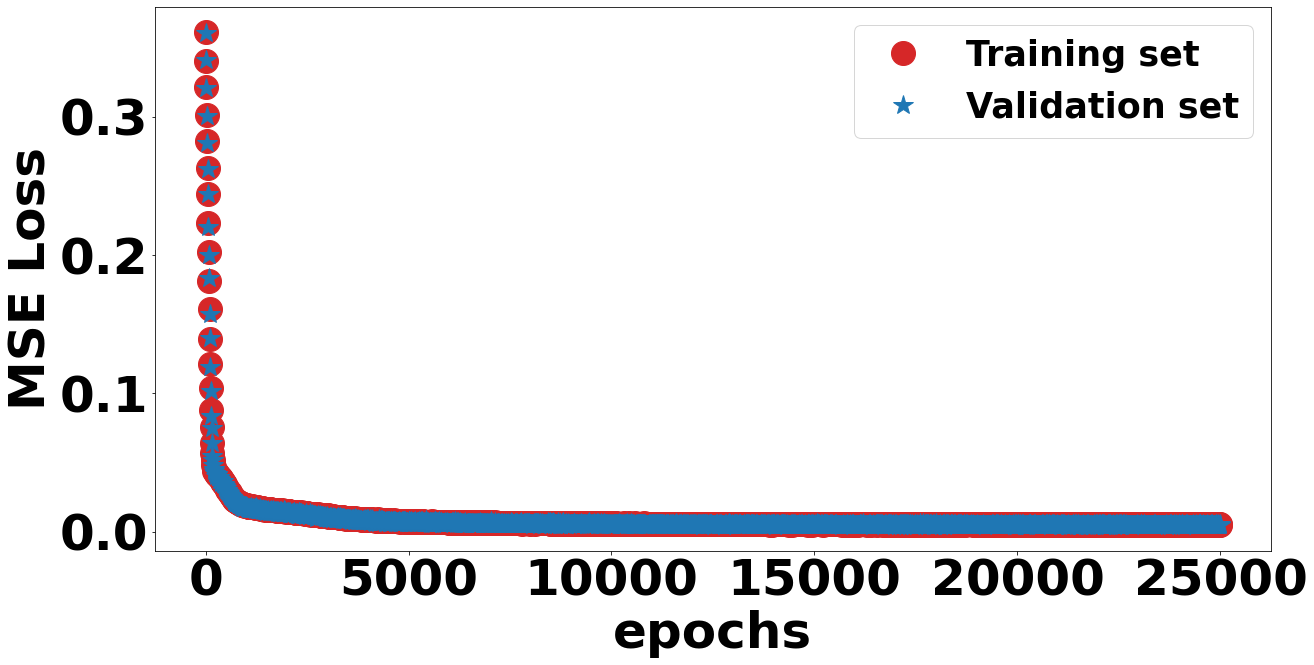

In [ ]:

##################################################################
################## plotting the MSE loss###########################
plt.figure()
#plt.suptitle('PCF - MSE Loss ', fontsize=95, color='r', fontweight='bold')     ## giving title on top of all subplots

#plt.subplot(331)
plt.plot(running_loss_index, running_loss, 'C3o', markersize=24, label='Training set')
plt.plot(running_loss_validation_index, running_loss_validation, 'C0*', markersize=20, label= 'Validation set')
plt.rcParams.update({'font.size': 50})
plt.legend(loc='best', fontsize=35)
plt.xlabel('epochs', fontsize=50)
plt.ylabel('MSE Loss', fontsize=50)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [1.4467   1.44116  1.43519  1.428834 1.42213  1.41511  1.40784  1.40035
 1.39268  1.38489 ]
predicted o/p of test set: 
 [1.4376744 1.4336982 1.4298677 1.4263272 1.4215169 1.4145908 1.407068
 1.398933  1.3907735 1.3826138]
mse_test_set:  0.007958390821230003


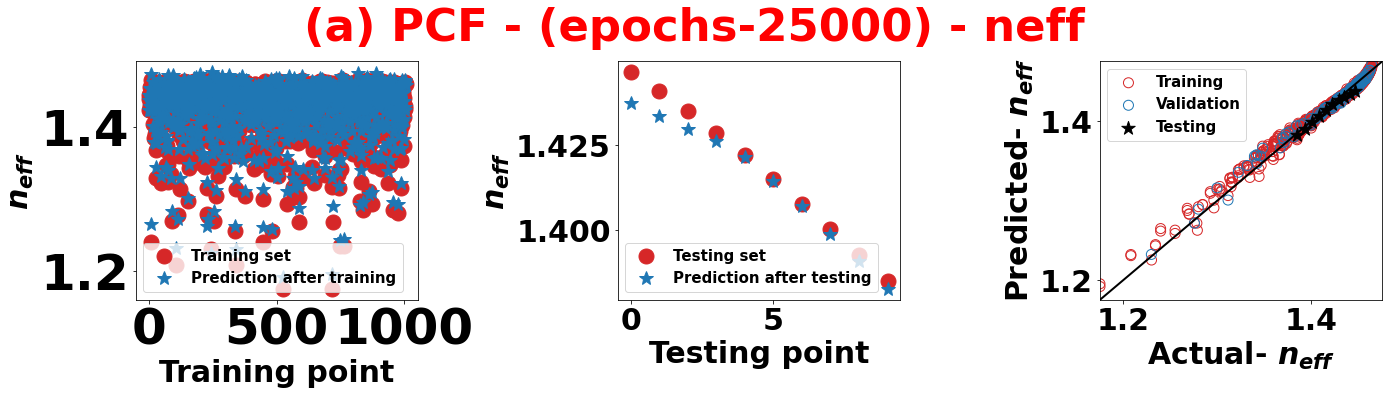

In [ ]:

###############################################################
#################   plotting graphs together - neff  ################
###############################################################

plt.figure()
#H\u2082O\u2082
plt.suptitle('(a) PCF - (epochs-{}) - neff'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

#plt.subplot(231)
#plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
#plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
#plt.legend(loc='best', fontsize=10)
#plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,0], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,0], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel('$n_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
#plt.subplot(233)
# Plot true data
#plt.plot(scaler2.inverse_transform(y_validation)[:,0], 'ro', markersize=3, label='y_validation')
# Plot predictions
#plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,0], 'b*', markersize=3, label='predicted_on_X_validation')
# Legend and plot
#plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,0], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,0], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel('$n_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,0]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,0]
xx_validation = scaler2.inverse_transform(y_validation)[:,0]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,0]
xx_test = scaler2.inverse_transform(y_test)[:,0]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,0]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel('Actual- $n_{eff}$', fontsize=30)
plt.ylabel('Predicted- $n_{eff}$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#plt.tight_layout(pad=0.0001)
# plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,0]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,0]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,0]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,0]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))
#plt.show()


# New Section

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [1.9506564 2.0474215 2.1509953 2.2628443 2.3705616 2.46513   2.5785153
 2.7449386 2.912973  3.0810091]
mse_test_set:  0.007958390821230003


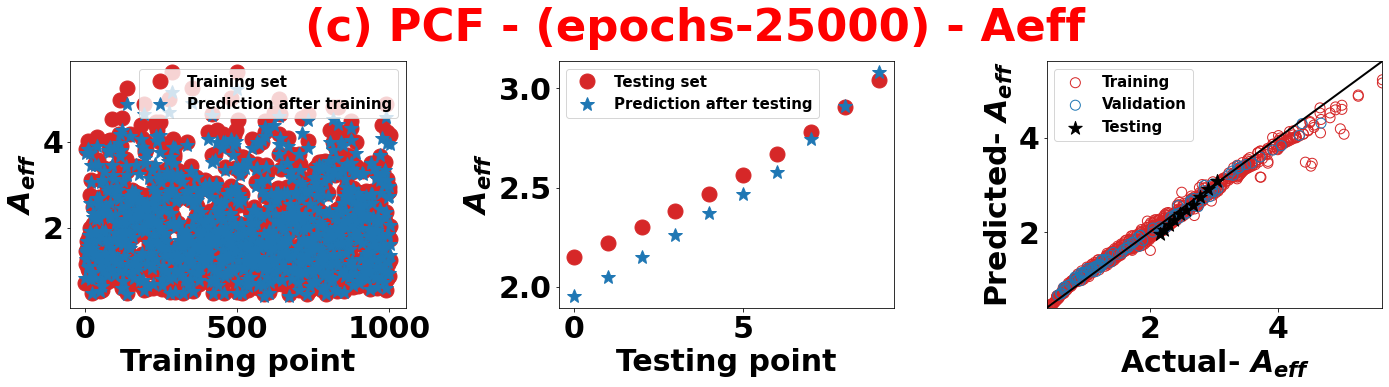

In [ ]:

###############################################################
#################   plotting graphs together - Aeff  ################
###############################################################

plt.figure()
plt.suptitle('(c) PCF - (epochs-{}) - Aeff'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(164)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,1], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,1], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel('$A_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,1], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,1], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,1], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,1], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel('$A_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,1]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,1]
xx_validation = scaler2.inverse_transform(y_validation)[:,1]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,1]
xx_test = scaler2.inverse_transform(y_test)[:,1]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,1]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel('Actual- $A_{eff}$', fontsize=30)
plt.ylabel('Predicted- $A_{eff}$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,1]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,1]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [126.183  129.341  129.864  127.624  122.422  114.007  102.097   86.4249
  66.7628  42.9646]
predicted o/p of test set: 
 [141.54994  134.1707   131.41743  119.0156   104.66703   88.005745
  68.353226  50.26507   32.26535   14.265631]
mse_test_set:  0.00815747338979889


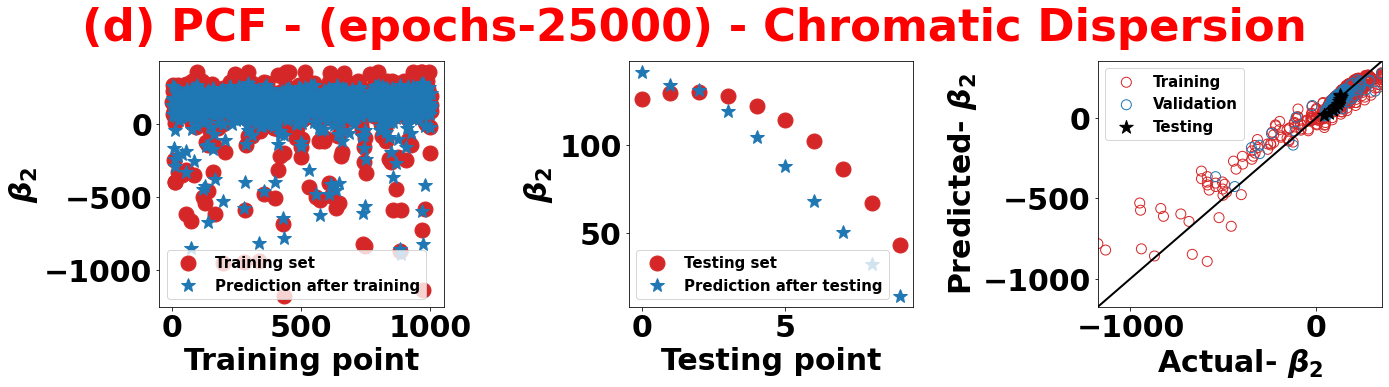

In [ ]:

# ####################################################################################################
# ###########    saving predicted data to excel file   ##############
# plt.show()
# n1 = xx
# n2 = yy
# n3 = true_values
# n4 = predicted_values
# n5 = error_values
# ## convert your array into a dataframe
# # df = pd.DataFrame(l1, columns=['a'])
# df1 = pd.DataFrame(OrderedDict({'y_train':n1, 'predicted_on_X_train':n2}))
# df2 = pd.DataFrame({'y_test':n3, 'predicted_on_X_test':n4, 'error_values':n5}, 
#                         columns=['y_test', 'predicted_on_X_test', 'error_values'])
# ## save to xlsx file
# # filepath_1 = 'test_excel_file_1.xlsx'
# df1.to_excel('test_excel_file_1.xlsx', sheet_name='sheet1', index=False)
# df2.to_excel('test_excel_file_2.xlsx', sheet_name='sheet1', index=False)
# # sys.exit()
# ####################################################################################################

###############################################################
#################   plotting graphs together - disp  ################
###############################################################

plt.figure()
plt.suptitle('(d) PCF - (epochs-{}) - Chromatic Dispersion'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,2], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,2], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\beta_2$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,2], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,2], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,2], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,2], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\beta_2$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,2]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,2]
xx_validation = scaler2.inverse_transform(y_validation)[:,2]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,2]
xx_test = scaler2.inverse_transform(y_test)[:,2]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,2]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\beta_2$', fontsize=30)
plt.ylabel(r'Predicted- $\beta_2$', fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,2]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,2]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,2]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,2]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [7.86184e-13 1.16957e-11 1.52937e-10 1.72620e-09 1.66735e-08 1.37772e-07
 9.78811e-07 6.02749e-06 3.24724e-05 1.54506e-04]
predicted o/p of test set: 
 [-0.06853716  0.01271241  0.14227022  0.19052602  0.204069    0.1880895
  0.16240945  1.5301464   2.9765997   4.423056  ]
mse_test_set:  0.00815747338979889


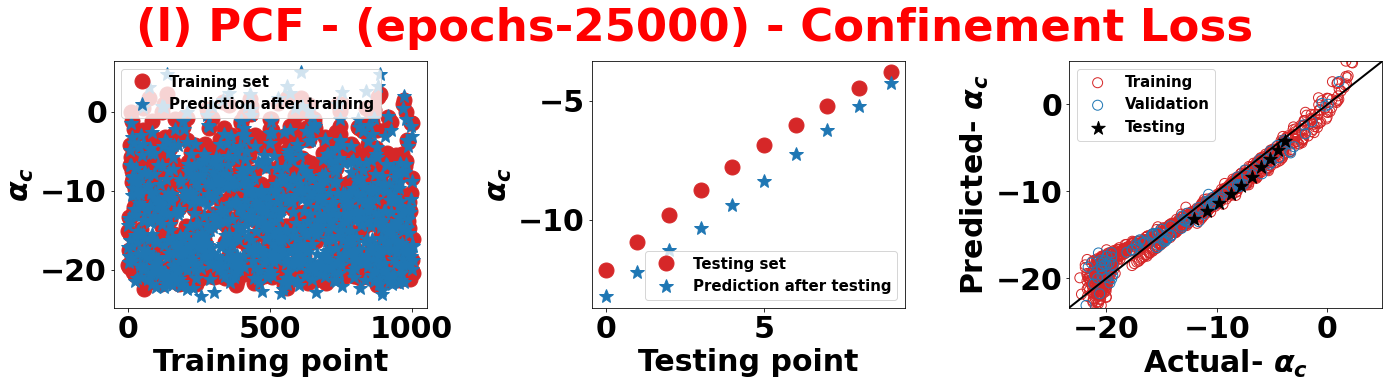

In [ ]:

###############################################################
#################   plotting graphs together - conf-loss  ################
###############################################################

plt.figure()
plt.suptitle('(l) PCF - (epochs-{}) - Confinement Loss'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,4], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,4], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\alpha_c$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,3], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,3], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,4], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,4], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\alpha_c$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,4]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,4]
xx_validation = scaler2.inverse_transform(y_validation)[:,4]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,4]
xx_test = scaler2.inverse_transform(y_test)[:,4]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,4]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\alpha_c$', fontsize=30)
plt.ylabel(r'Predicted- $\alpha_c$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,3]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,3]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,3]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,3]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

# ###############################################################
# #################   plotting graphs together - conf-loss-in-log10  ################
# ###############################################################

# plt.figure()
# plt.suptitle('PCF - (epochs-{}) - Confinement Loss'.format(epochs), fontsize=25, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# # plt.figure()
# plt.subplot(232)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_train)[:,4], 'ro', markersize=12, label='y_train')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,4], 'b*', markersize=12, label='predicted_on_X_train')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,4], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,4], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# # plt.figure()
# plt.subplot(234)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_test)[:,4], 'ro', markersize=12, label='y_test')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,4], 'b*', markersize=12, label='predicted_on_X_test')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# # plt.figure()
# plt.subplot(235)
# xx = scaler2.inverse_transform(y_train)[:,4]
# yy = scaler2.inverse_transform(predicted_on_X_train)[:,4]
# xx_validation = scaler2.inverse_transform(y_validation)[:,4]
# yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,4]
# xx_test = scaler2.inverse_transform(y_test)[:,4]
# yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,4]
# bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
# bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
# plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
# plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
# plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
# plt.grid(linestyle='--', linewidth=1)
# plt.scatter(xx, yy, label='train', marker='o', facecolors='', edgecolors='red', s=50)
# plt.scatter(xx_validation, yy_validation, label='validation', marker='o', facecolors='', edgecolors='blue', s=50)
# plt.scatter(xx_test, yy_test, label='test', marker='o', facecolors='', edgecolors='black', s=50)
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('true-values', fontsize=15)
# plt.ylabel('predicted', fontsize=15)

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,4]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,4]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

# print()
# print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,4]))
# print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,4]))
# print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))



###############################################################
#################   plotting graphs together - conf-loss-without/with-log10  ################
###############################################################

# plt.figure()
# plt.subplot(121)
# true_values = scaler2.inverse_transform(y_test)[:,3]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,3]
# print(true_values)
# print(predicted_values)
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10)
# plt.yscale('log')
# plt.grid(linestyle='--', linewidth=1)
# plt.title('conf-loss-without-log10', fontsize=25)

# plt.subplot(122)
# true_values = 10**(scaler2.inverse_transform(y_test)[:,4])
# predicted_values = 10**(scaler2.inverse_transform(predicted_on_X_test)[:,4])
# print(true_values)
# print(predicted_values)
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10)
# plt.yscale('log')                    
# plt.grid(linestyle='--', linewidth=1)
# plt.title('conf-loss-with-log10', fontsize=25)

# ####################################################################################################
# ###########    saving predicted data to excel file   ##############
# plt.show()
xx = scaler2.inverse_transform(y_train)[:,3]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,3]
true_values = scaler2.inverse_transform(y_test)[:,3]
predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,3]
error_values = predicted_values - true_values

n1 = xx
n2 = yy
n3 = true_values
n4 = predicted_values
n5 = error_values
# ## convert your array into a dataframe
# # df = pd.DataFrame(l1, columns=['a'])
df1 = pd.DataFrame(OrderedDict({'y_train':n1, 'predicted_on_X_train':n2}))
df2 = pd.DataFrame({'y_test':n3, 'predicted_on_X_test':n4, 'error_values':n5},
                    columns=['y_test', 'predicted_on_X_test', 'error_values'])
# ## save to xlsx file
# # filepath_1 = 'test_excel_file_1.xlsx'
df1.to_excel('conf-loss-without-log10_1.xlsx', sheet_name='sheet1', index=False)
df2.to_excel("conf-loss-without-log10_2.xlsx", sheet_name="sheet2", index=False)
# # sys.exit()

######################################################################################################
###########    saving predicted data to excel file   ##############
l1 = 10**(scaler2.inverse_transform(y_test)[:,4])                     #### check multiple of 10
l2 = 10**(scaler2.inverse_transform(predicted_on_X_test)[:,4])        #### check multiple of 10
###########    saving mse data to excel file   ##############
l3 = running_loss
l4 = running_loss_validation
l5 = running_loss_index
l6 = running_loss_validation_index

## convert your array into a dataframe
# df = pd.DataFrame(l1, columns=['a'])
df = pd.DataFrame({'a':l3, 'b':l4})

## save to xlsx file
filepath = 'test_excel_file.xlsx'
df.to_excel(filepath, sheet_name='sheet1', index=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [2.0498328 2.1614046 2.2288463 2.3344789 2.4599068 2.580643  2.6879704
 2.8584669 3.032533  3.2065985]
mse_test_set:  0.00815747338979889


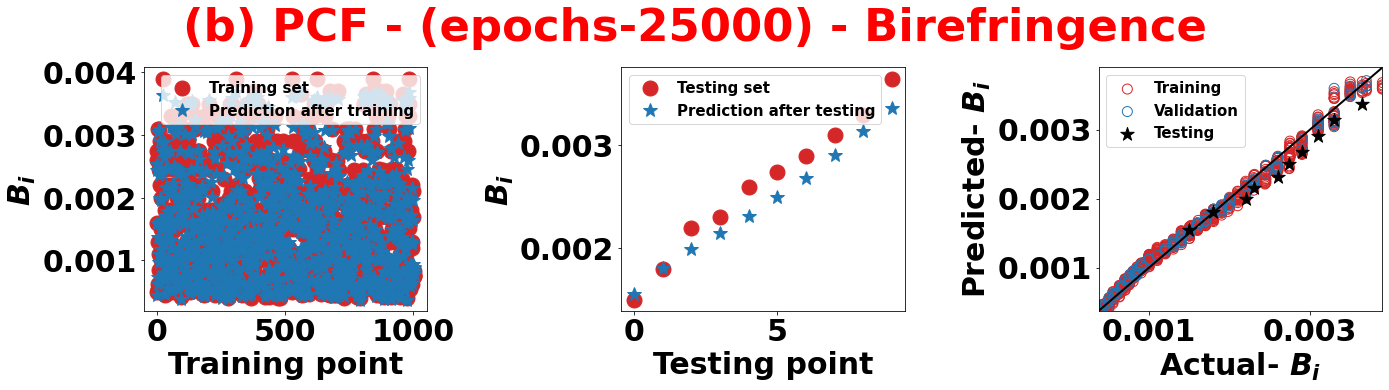

In [ ]:


# sys.exit()
###############################################################
#################   plotting graphs together - Birefringence  ################
###############################################################

plt.figure()
plt.suptitle('(b) PCF - (epochs-{}) - Birefringence'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,5], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,5], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.xlabel('Training point', fontsize=30)
plt.ylabel('$B_i$', fontsize=30)
plt.legend(loc='best', fontsize=15)
plt.rcParams.update({'font.size': 30})


# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,5], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,5], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,5], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,5], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.xlabel('Testing point', fontsize=30)
plt.ylabel('$B_i$', fontsize=30)
plt.legend(loc='best', fontsize=15)
plt.rcParams.update({'font.size': 30})

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,5]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,5]
xx_validation = scaler2.inverse_transform(y_validation)[:,5]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,5]
xx_test = scaler2.inverse_transform(y_test)[:,5]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,5]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)

plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100,)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200,)

plt.legend(loc='best', fontsize=15)
plt.xlabel('Actual- $B_i$', fontsize=30)
plt.ylabel('Predicted- $B_i$', fontsize=30)

plt.rcParams.update({'font.size': 30})
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


plt.xticks([0.001, 0.003])
#plt.set_xticklabels([1,4,5], fontsize=12)
#plt.xticks(range(2),['A', 'Big', 'Cat'], color='black')

#major_ticks = np.arange(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1], 0.015)
#plt.set_xtick(major_ticks)

#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=1, hspace=1)
#plt.subplot_tool()
#plt.subplots(constrained_layout=True)
#plt.rcParams['figure.constrained_layout.use'] = True
#fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)

# plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,5]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,5]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [2.0498328 2.1614046 2.2288463 2.3344789 2.4599068 2.580643  2.6879704
 2.8584669 3.032533  3.2065985]
mse_test_set:  0.00815747338979889


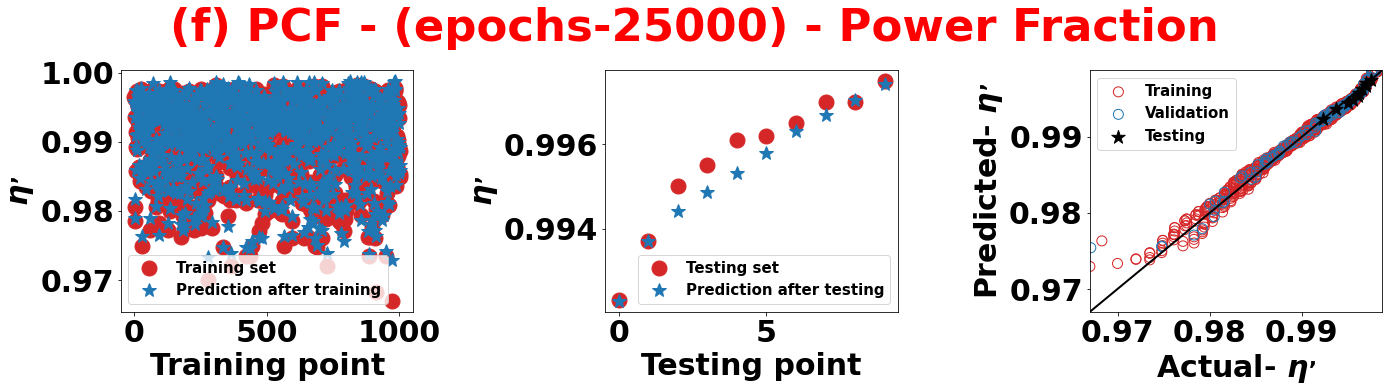

In [ ]:

###############################################################
#################   plotting graphs together - Power fraction  ################
###############################################################

plt.figure()

plt.suptitle('(f) PCF - (epochs-{}) - Power Fraction'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,6], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,6], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\eta^,$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,6], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,6], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,6], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,6], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\eta^,$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,6]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,6]
xx_validation = scaler2.inverse_transform(y_validation)[:,6]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,6]
xx_test = scaler2.inverse_transform(y_test)[:,6]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,6]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\eta^,$', fontsize=30)
plt.ylabel(r'Predicted- $\eta^,$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,6]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,6]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [2.0498328 2.1614046 2.2288463 2.3344789 2.4599068 2.580643  2.6879704
 2.8584669 3.032533  3.2065985]
mse_test_set:  0.00815747338979889


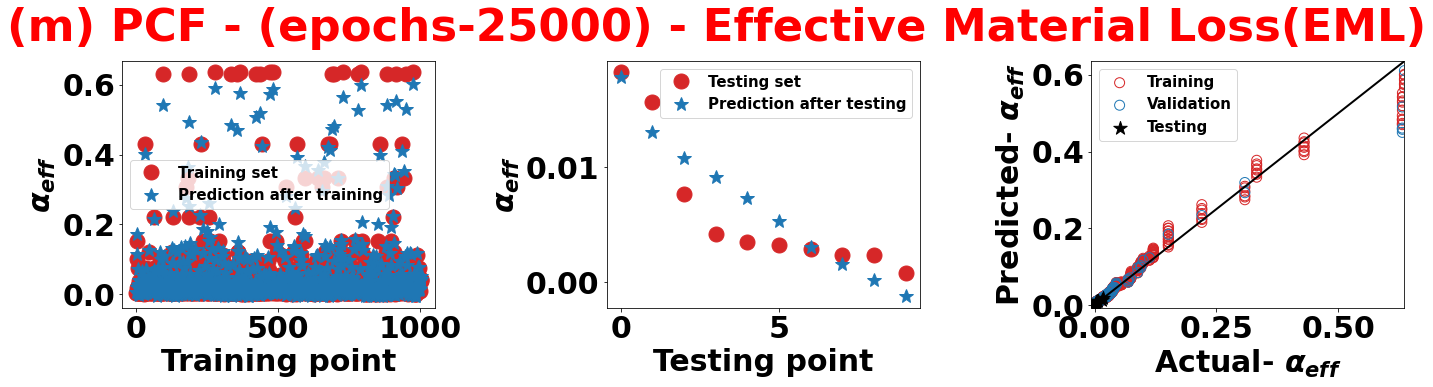

In [ ]:

###############################################################
#################   plotting graphs together - EML  ################
###############################################################

plt.figure()
plt.suptitle('(m) PCF - (epochs-{}) - Effective Material Loss(EML)'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots
#plt.suptitle('pcf - Effective Material Loss(EML) - (epochs-{}) - pyTorch'.format(epochs), fontsize=25, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,7], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,7], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\alpha_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,7], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,7], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform((y_test))[:,7], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,7], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\alpha_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,7]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,7]
xx_validation = scaler2.inverse_transform(y_validation)[:,7]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,7]
xx_test = scaler2.inverse_transform(y_test)[:,7]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,7]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\alpha_{eff}$', fontsize=30)
plt.ylabel(r'Predicted- $\alpha_{eff}$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,7]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,7]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [1.9506564 2.0474215 2.1509953 2.2628443 2.3705616 2.46513   2.5785153
 2.7449386 2.912973  3.0810091]
mse_test_set:  0.007958390821230003


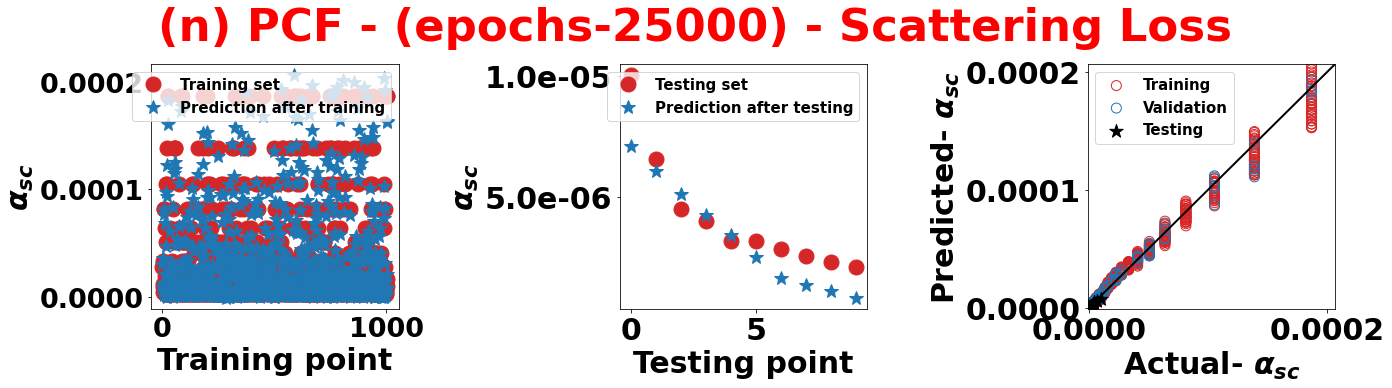

In [ ]:

###############################################################
#################   plotting graphs together - Scattering Loss  ################
###############################################################

plt.figure()
plt.suptitle('(n) PCF - (epochs-{}) - Scattering Loss'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,8], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,8], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\alpha_{sc}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,8], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,8], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
ax = plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,8], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,8], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\alpha_{sc}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,8]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,8]
xx_validation = scaler2.inverse_transform(y_validation)[:,8]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,8]
xx_test = scaler2.inverse_transform(y_test)[:,8]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,8]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\alpha_{sc}$', fontsize=30)
plt.ylabel(r'Predicted- $\alpha_{sc}$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,8]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,8]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.



o/p of test set:           
 [2.14976 2.22181 2.29861 2.38074 2.46894 2.56412 2.66742 2.78024 2.90433
 3.04184]
predicted o/p of test set: 
 [1.9506564 2.0474215 2.1509953 2.2628443 2.3705616 2.46513   2.5785153
 2.7449386 2.912973  3.0810091]
mse_test_set:  0.007958390821230003


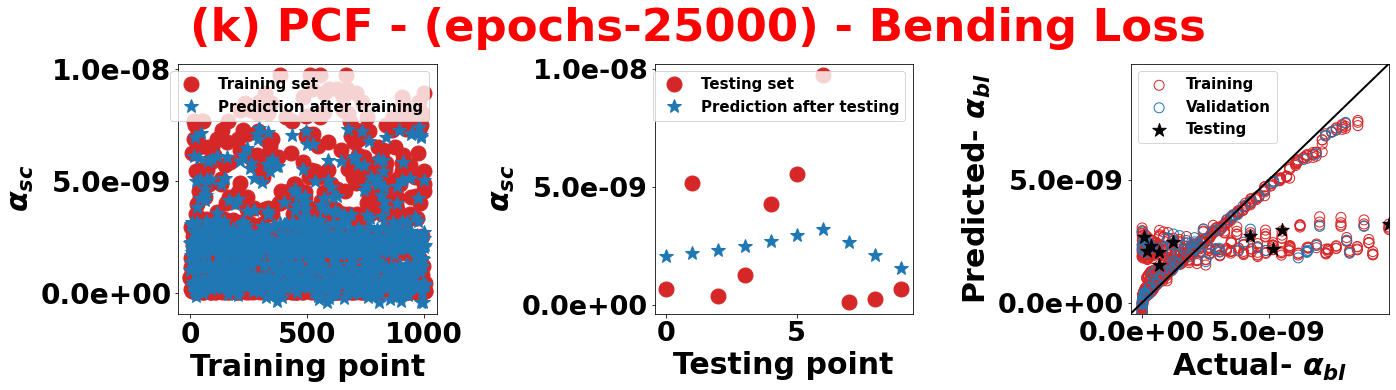

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
###############################################################
#################   plotting graphs together - Bending Loss  ################
###############################################################

plt.figure()
plt.suptitle('(k) PCF - (epochs-{}) - Bending Loss'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
ax=plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,9], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,9], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot

#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

plt.rcParams.update({'font.size': 27})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\alpha_{sc}$', fontsize=30)
plt.legend(loc='best', fontsize=15)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,9], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,9], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
ax=plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,9], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,9], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
#ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.rcParams.update({'font.size': 27})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\alpha_{sc}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
ax = plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,9]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,9]
xx_validation = scaler2.inverse_transform(y_validation)[:,9]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,9]
xx_test = scaler2.inverse_transform(y_test)[:,9]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,9]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)

#plt.ticklabel_format(useOffset=False, style='plain')


plt.rcParams.update({'font.size': 27})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\alpha_{bl}$', fontsize=30)
plt.ylabel(r'Predicted- $\alpha_{bl}$', fontsize=30)

ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,9]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,9]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

###############################################################
#################   plotting graphs together - Transmittance  ################
###############################################################

plt.figure()
plt.suptitle('(i) PCF - (epochs-{}) - Transmittance'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,10], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,10], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel('$T_x$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,10], 'ro', markersize=15, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,10], 'b*', markersize=15, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,10], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,10], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel('$T_x$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,10]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,10]
xx_validation = scaler2.inverse_transform(y_validation)[:,10]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,10]
xx_test = scaler2.inverse_transform(y_test)[:,10]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,10]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel('Actual- $T_x$', fontsize=30)
plt.ylabel('Predicted- $T_x$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,10]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,10]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

###############################################################
#################   plotting graphs together - Relative Sensitivity  ################
###############################################################

plt.figure()
plt.suptitle('(h) PCF - (epochs-{}) - Relative Sensitivity'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,11], 'C3o', markersize=12, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,11], 'C0*', markersize=12, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$R_s$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,11], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,11], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,11], 'C3o', markersize=12, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,11], 'C0*', markersize=12, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$R_s$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,11]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,11]
xx_validation = scaler2.inverse_transform(y_validation)[:,11]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,11]
xx_test = scaler2.inverse_transform(y_test)[:,11]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,11]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $R_s$', fontsize=30)
plt.ylabel(r'Predicted- $R_s$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,11]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,11]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

###############################################################
#################   plotting graphs together - Numerical Aperture  ################
###############################################################

plt.figure()
plt.suptitle('(e) PCF - (epochs-{}) - Numerical Aperture'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,12], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,12], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$NA$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,12], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,12], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,12], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,12], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$NA$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,12]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,12]
xx_validation = scaler2.inverse_transform(y_validation)[:,12]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,12]
xx_test = scaler2.inverse_transform(y_test)[:,12]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,12]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $NA$', fontsize=30)
plt.ylabel(r'Predicted- $NA$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,12]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,12]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

###############################################################
#################   plotting graphs together - Nonlinearity  ################
###############################################################

plt.figure()
plt.suptitle('(g) PCF - (epochs-{}) - Nonlinearity'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,13], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,13], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$\gamma$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,13], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,13], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)

# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,13], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,13], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$\gamma$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,13]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,13]
xx_validation = scaler2.inverse_transform(y_validation)[:,13]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,13]
xx_test = scaler2.inverse_transform(y_test)[:,13]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,13]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $\gamma$', fontsize=30)
plt.ylabel(r'Predicted- $\gamma$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# # plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,13]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,13]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

###############################################################
#################   plotting graphs together - Veff  ################
###############################################################

plt.figure()
plt.suptitle('(j) PCF - (epochs-{}) - Veff'.format(epochs), fontsize=45, color='r', fontweight='bold')     ## giving title on top of all subplots

# plt.subplot(231)
# plt.plot(running_loss_index, running_loss, 'r-', linewidth=3, label='mse_loss_train')
# plt.plot(running_loss_validation_index, running_loss_validation, 'b-', linewidth=3, label='mse_loss_validation')
# plt.legend(loc='best', fontsize=10)
# plt.xlabel('epochs#', fontsize=15)

# plt.figure()
plt.subplot(231)
# Plot true data
plt.plot(scaler2.inverse_transform(y_train)[:,14], 'C3o', markersize=15, label='Training set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_train)[:,14], 'C0*', markersize=15, label='Prediction after training')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Training point', fontsize=30)
plt.ylabel(r'$V_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# # plt.figure()
# plt.subplot(233)
# # Plot true data
# plt.plot(scaler2.inverse_transform(y_validation)[:,14], 'ro', markersize=12, label='y_validation')
# # Plot predictions
# plt.plot(scaler2.inverse_transform(predicted_on_X_validation)[:,14], 'b*', markersize=12, label='predicted_on_X_validation')
# # Legend and plot
# plt.legend(loc='best', fontsize=10)


# plt.figure()
plt.subplot(232)
# Plot true data
plt.plot(scaler2.inverse_transform(y_test)[:,14], 'C3o', markersize=15, label='Testing set')
# Plot predictions
plt.plot(scaler2.inverse_transform(predicted_on_X_test)[:,14], 'C0*', markersize=15, label='Prediction after testing')
# Legend and plot
plt.rcParams.update({'font.size': 30})
plt.xlabel('Testing point', fontsize=30)
plt.ylabel(r'$V_{eff}$', fontsize=30)
plt.legend(loc='best', fontsize=15)

# plt.figure()
plt.subplot(233)
xx = scaler2.inverse_transform(y_train)[:,14]
yy = scaler2.inverse_transform(predicted_on_X_train)[:,14]
xx_validation = scaler2.inverse_transform(y_validation)[:,14]
yy_validation = scaler2.inverse_transform(predicted_on_X_validation)[:,14]
xx_test = scaler2.inverse_transform(y_test)[:,14]
yy_test = scaler2.inverse_transform(predicted_on_X_test)[:,14]
bubble_plot_line_x1y1 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
bubble_plot_line_x2y2 = [min(np.minimum(xx,yy)), max(np.maximum(xx,yy))]
plt.xlim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.ylim(bubble_plot_line_x1y1[0], bubble_plot_line_x1y1[1])
plt.plot(bubble_plot_line_x1y1, bubble_plot_line_x2y2, 'k-', linewidth=2)
#plt.grid(linestyle='--', linewidth=1)
plt.scatter(xx, yy, label='Training', marker='o', facecolors='', edgecolors='C3', s=100)
plt.scatter(xx_validation, yy_validation, label='Validation', marker='o', facecolors='', edgecolors='C0', s=100)
plt.scatter(xx_test, yy_test, label='Testing', marker='*', facecolors='black', edgecolors='black', s=200)
plt.rcParams.update({'font.size': 30})
plt.legend(loc='best', fontsize=15)
plt.xlabel(r'Actual- $V_{eff}$', fontsize=30)
plt.ylabel(r'Predicted- $V_{eff}$', fontsize=30)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# plt.figure()
# plt.subplot(236)
# true_values = scaler2.inverse_transform(y_test)[:,14]
# predicted_values = scaler2.inverse_transform(predicted_on_X_test)[:,14]
# x_index = [i for i in range(len(true_values))]
# error_values = predicted_values - true_values
# plt.errorbar(x=x_index, y=true_values, yerr=error_values, fmt='o', color='black', 
#                     ecolor='black', elinewidth=2, capsize=10);
# plt.grid(linestyle='--', linewidth=1)

print()
print("o/p of test set:           \n", (scaler2.inverse_transform(y_test)[:,1]))
print("predicted o/p of test set: \n", (scaler2.inverse_transform(predicted_on_X_test)[:,1]))
print("mse_test_set: ", mean_squared_error(y_test, predicted_on_X_test))


In [ ]:

# ####################################################################################################



###################################################################################################
plt.show()

##########################################
#######           GUI           ##########
##########################################

plt.figure(figsize=(4, 3))
fig = plt.gcf()      # if using Pyplot then get the figure from the plot
figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds
print(figure_w)



"""
Demonstrates one way of embedding Matplotlib figures into a PySimpleGUI window.
Basic steps are:
 * Create a Canvas Element
 * Layout form
 * Display form (NON BLOCKING)
 * Draw plots onto convas
 * Display form (BLOCKING)
"""

def draw_figure(canvas, figure, loc=(0, 0)):
    """ Draw a matplotlib figure onto a Tk canvas
    loc: location of top-left corner of figure on canvas in pixels.
    Inspired by matplotlib source: lib/matplotlib/backends/backend_tkagg.py
    """
    figure_canvas_agg = FigureCanvasAgg(figure)
    figure_canvas_agg.draw()
    figure_x, figure_y, figure_w, figure_h = figure.bbox.bounds
    figure_w, figure_h = int(figure_w), int(figure_h)
    photo = Tk.PhotoImage(master=canvas, width=figure_w, height=figure_h)
    canvas.create_image(loc[0] + figure_w/2, loc[1] + figure_h/2, image=photo)
    tkagg.blit(photo, figure_canvas_agg.get_renderer()._renderer, colormode=2)
    return photo

layout = [
    [
    sg.Image(filename='hexagonal_pcf_image.PNG', size=(250, 250)),
    sg.Text('\n Hexagonal \n PCF', size=(15, 4), background_color='orange', justification='center', font=("Helvetica", 40), relief=sg.RELIEF_RIDGE)],
    [sg.Text('_'  * 100)],
    [sg.Frame('Material',[
        # [sg.Text('')],
        [sg.Text('Core  ', font=("Helvetica", 20), text_color=''), sg.Radio('Silica', "RADIO1", default=True, key='core_silica'), 
        # sg.Radio('ChG', "RADIO1", key='core_ChG')
        ],
        # [sg.Text('')],
        [sg.Text('Holes ', font=("Helvetica", 20), text_color=''), sg.Radio('Air', "RADIO2", default=True, key='holes_air')],
		], font=("Helvetica", 20), title_color='blue'),
    sg.Frame('Wavelength (um)',[
		[sg.Slider(range=(0.5, 1.8), resolution=0.005, orientation='h', size=(15, 20), default_value=1.55, key='wavelength')]], font=("Helvetica", 20), title_color='blue'),
    sg.Frame('Parameters',[
        [sg.Text('No. of Rings', font=("Helvetica", 20), text_color=''), sg.Radio('4', "RADIO3", default=True, key='no_of_rings_4'), sg.Radio('5', "RADIO3", key='no_of_rings_5')],
 		[sg.Text('Pitch (um)  ', font=("Helvetica", 20), text_color=''), sg.Slider(range=(0.8, 2), resolution=0.1, orientation='h', size=(15, 20), default_value=1.5, key='pitch')],
        [sg.Text('Dia by Pitch', font=("Helvetica", 20), text_color=''), sg.Radio('0.6', "RADIO4", key='diaBYpitch_0.6'), sg.Radio('0.7', "RADIO4", default=True, key='diaBYpitch_0.7'),],
 		[sg.Text('                  ', font=("Helvetica", 20),), sg.Radio('0.8', "RADIO4", key='diaBYpitch_0.8'), sg.Radio('0.9', "RADIO4", key='diaBYpitch_0.9'),]
        ], font=("Helvetica", 20), title_color='blue')
        ],
    [sg.Text('_'  * 100)],    
    [sg.Button('Calculate', tooltip='Click to calculate various values...', button_color=('white', 'green'), size=(10,2), font=("Helvetica", 25)),
    sg.Text(' '  * 8),
    sg.Frame('neff',[[
		sg.Multiline(default_text=' ', key='neff', size=(10, 3))
		]], font=("Helvetica", 10), title_color='red'),
    sg.Frame('Aeff (um^2)',[[
		sg.Multiline(default_text=' ', key='Aeff', size=(10, 3))
		]], font=("Helvetica", 10), title_color='red'),
    sg.Frame('Disp (ps/Km.nm)',[[
		sg.Multiline(default_text=' ', key='disp', size=(10, 3))
		]], font=("Helvetica", 10), title_color='red'),
    # sg.Frame('Lc (dB/cm)',[[
	# 	sg.Multiline(default_text=' ', key='conf_loss', size=(10, 3))
	# 	]], font=("Helvetica", 10), title_color='red'),
    sg.Frame('Lc-using-Log (dB/cm)',[[
		sg.Multiline(default_text=' ', key='conf_loss_using_log', size=(10, 3))
		]], font=("Helvetica", 10), title_color='red'),    
    # sg.Canvas(size=(figure_w, figure_h), key='canvas')    
    ],
    [sg.Button('Exit', tooltip='Click to exit the window...', button_color=('black', 'red'), size=(10,2), font=("Helvetica", 15))]
]

window = sg.Window('PCF', layout, location=(400,25), 
						default_element_size=(40, 1), grab_anywhere=False,
						resizable=True, background_color=None, font=("Helvetica", 13))

#event, values = window.Read()

def calculate_values():
    
    print()
    print('core_silica: ', values['core_silica'])
    # print('core_ChG: ', values['core_ChG'])
    print('holes_air: ', values['holes_air'])
    print('wavelength (um): ', values['wavelength'])
    print('no_of_rings_4: ', values['no_of_rings_4'])
    print('no_of_rings_5: ', values['no_of_rings_5'])
    print('pitch (um)    : ', values['pitch'])
    print('diaBYpitch_0.6: ', values['diaBYpitch_0.6'])
    print('diaBYpitch_0.7: ', values['diaBYpitch_0.7'])
    print('diaBYpitch_0.8: ', values['diaBYpitch_0.8'])
    print('diaBYpitch_0.9: ', values['diaBYpitch_0.9'])


    if (values['core_silica'] == True):
        core_ref = 1.444
    # elif (values['core_ChG'] == True):
    #     core_ref = 2.567  

    if (values['holes_air'] == True):
        holes_ref = 1.0
    
    if (values['no_of_rings_4'] == True):
        no_of_rings = 4
    elif (values['no_of_rings_5'] == True):
        no_of_rings = 5
        
    
    if (values['diaBYpitch_0.6'] == True):
        diaBYpitch = 0.6
    elif (values['diaBYpitch_0.7'] == True):
        diaBYpitch = 0.7
    elif (values['diaBYpitch_0.8'] == True):
        diaBYpitch = 0.8
    elif (values['diaBYpitch_0.9'] == True):
        diaBYpitch = 0.9
    

    ###########     manual testing from GUI   #########
    #### [[ core_ref, holes_ref, no_of_rings, diaBYpitch, wavelength, pitch,  zero-neff, zero-Aeff, zero-disp, zero-conf-loss, zero-conf-loss-in-log]]
    datafile_3 = np.array([[core_ref, holes_ref, no_of_rings, diaBYpitch, values['wavelength'], values['pitch'],  0, 0, 0, 0, 0]])
    scaler_datafile_3 = scaler1.transform(datafile_3)
    X_test_GUI = scaler_datafile_3[:,range(0,6)]
    print(datafile_3)
    print(X_test_GUI)
    ###################################################

    predicted_on_X_test_GUI = model(torch.Tensor(X_test_GUI)).data.numpy()
    print("\npredicted o/p of test set GUI: \n", scaler2.inverse_transform(predicted_on_X_test_GUI))
    
    print(predicted_on_X_test_GUI)
    print(scaler2.inverse_transform(predicted_on_X_test_GUI))
    print(scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,0), 
            scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,1),
            scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,2))
    X_test_GUI_neff = round(scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,0), 5)
    X_test_GUI_Aeff = round(scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,1), 5)
    X_test_GUI_disp = round(scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,2), 5)
    X_test_GUI_confLoss = format((scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,3)), '4E')
    ##### taking antilog to get the predicted conf loss (not in log values)   #####
    #####   use 'e or g, E or G'  for exponential format   ##### 
    X_test_GUI_confLossUsingLog = format(10**(scaler2.inverse_transform(predicted_on_X_test_GUI).item(0,4)), '.5E')
    print(X_test_GUI_neff, X_test_GUI_Aeff, X_test_GUI_disp, X_test_GUI_confLoss, X_test_GUI_confLossUsingLog)
    return X_test_GUI_neff, X_test_GUI_Aeff, X_test_GUI_disp, X_test_GUI_confLoss, X_test_GUI_confLossUsingLog





while True:                 # Event Loop
    event, values = window.Read()
    # sg.Popup('The results of the window-- ',
	# 		'The button clicked was "{}"'.format(event),
	# 		'The values are: ', values)

    if event is None or event == 'Exit':
        break
    if event == 'Calculate':
        X_test_GUI_updated = calculate_values()
        # change the "output" element to be the value of "input" element
        window.FindElement('neff').Update(X_test_GUI_updated[0])
        window.FindElement('Aeff').Update(X_test_GUI_updated[1])
        window.FindElement('disp').Update(X_test_GUI_updated[2])
        # window.FindElement('conf_loss').Update(X_test_GUI_updated[3])
        window.FindElement('conf_loss_using_log').Update(X_test_GUI_updated[4])
        # add the plot to the window
         #fig_photo = draw_figure(window.FindElement('canvas').TKCanvas, fig)


window.Close()